# Project 5 : Vehicle Detection and Tracking - Traditional CV Method

In [1]:
# Load required packages

import numpy as np
import cv2
import pickle
import time
import glob

from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

import cvfind_cars
import cvconfig

%matplotlib inline


In [2]:
# Static parameters from cvconfig file
color_space = cvconfig.color_space        # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = cvconfig.orient                  # HOG orientations
pix_per_cell = cvconfig.pix_per_cell      # HOG pixels per cell
cell_per_block = cvconfig.cell_per_block  # HOG cells per block
spatial_size = cvconfig.spatial_size      # Spatial binning dimensions
histbin = cvconfig.hist_bins              # Number of histogram bins
hog_channel = cvconfig.hog_channel        # Can be 0, 1, 2, or "ALL"
spatial_feat = cvconfig.spatial_feat      # Spatial features on or off
hist_feat = cvconfig.hist_feat            # Histogram features on or off
hog_feat = cvconfig.hog_feat              # HOG features on or off
heatmap_thresh = cvconfig.heatmap_thresh


In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict


# Define a function that takes an image, a list of bounding boxes, optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)

    all_cars = []
    # draw each bounding box on your image copy using cv2.rectangle()
    for (x1,y1),(x2,y2) in bboxes:
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
        car = draw_img[y1:y2,x1:x2]
        #cv2.resize(car,(0,0),fy=150)
        all_cars.append(car)
    # return the image copy with boxes drawn
    return draw_img, all_cars # Change this line to return image copy with boxes


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Function to show original and updated images together
def org_upd(org, org_title, updated, upd_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    f.tight_layout()
    ax1.imshow(org)
    ax1.set_title(org_title, fontsize=30)
    ax2.imshow(updated, 'gray')
    ax2.set_title(upd_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    
# Define a function to compute color histogram features  
def color_hist(image, nbins=32, bins_range=(0, 255)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 255))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 255))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 255))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features



Prepare a balanced dataset, i.e., have as many positive as negative examples, or in the case of multi-class problems, roughly the same number of cases of each class.

This is to avoid having algorithm simply classify everything as belonging to the majority class.

In [4]:
# Load images
car_images = glob.glob("./vehicles/*/*/*.png")
notcar_images = glob.glob("./non-vehicles/*/*/*.png")
cars = []
notcars = []

for image in car_images:
    cars.append(image)

for image in notcar_images:
    notcars.append(image)

data_info = data_look(cars, notcars)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Visualize car / not-car images

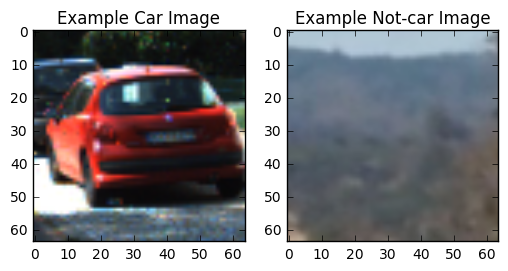

In [5]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


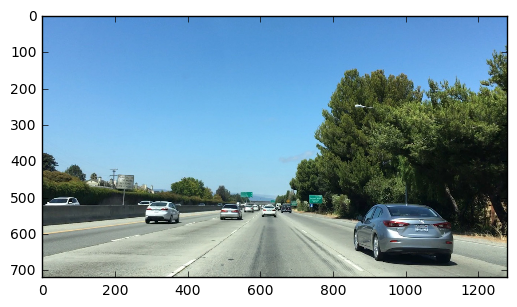

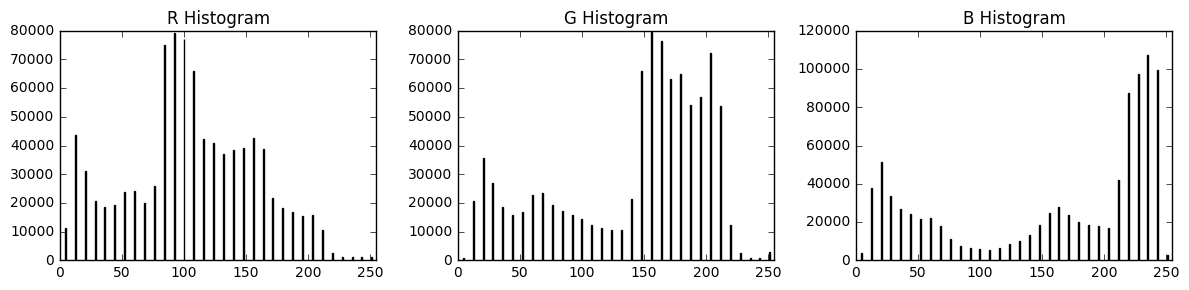

In [6]:
# Histogram of pixel intensity
# This transform is used to compute color values in an image
tst_img = mpimg.imread('test_images/bbox-example-image.jpg')
rh, gh, bh, bincen, feature_vec = color_hist(tst_img, nbins=32, bins_range=(0, 255))

plt.imshow(tst_img)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 255)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 255)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 255)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')


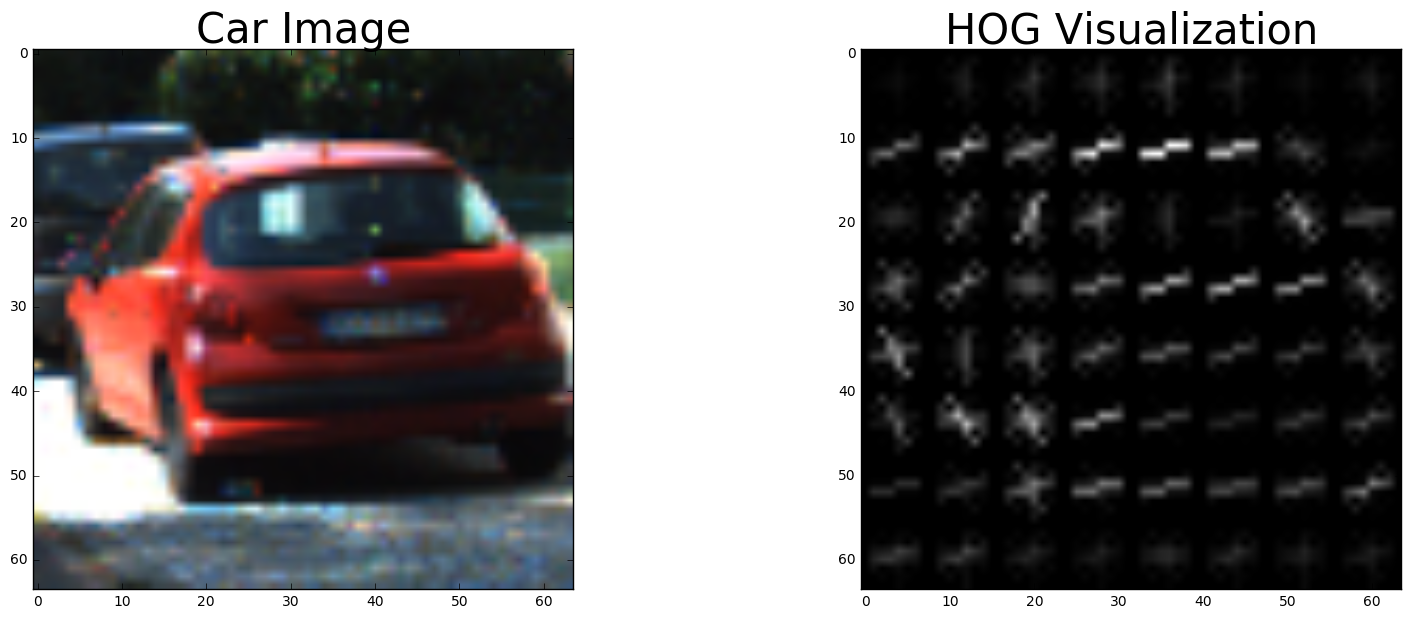

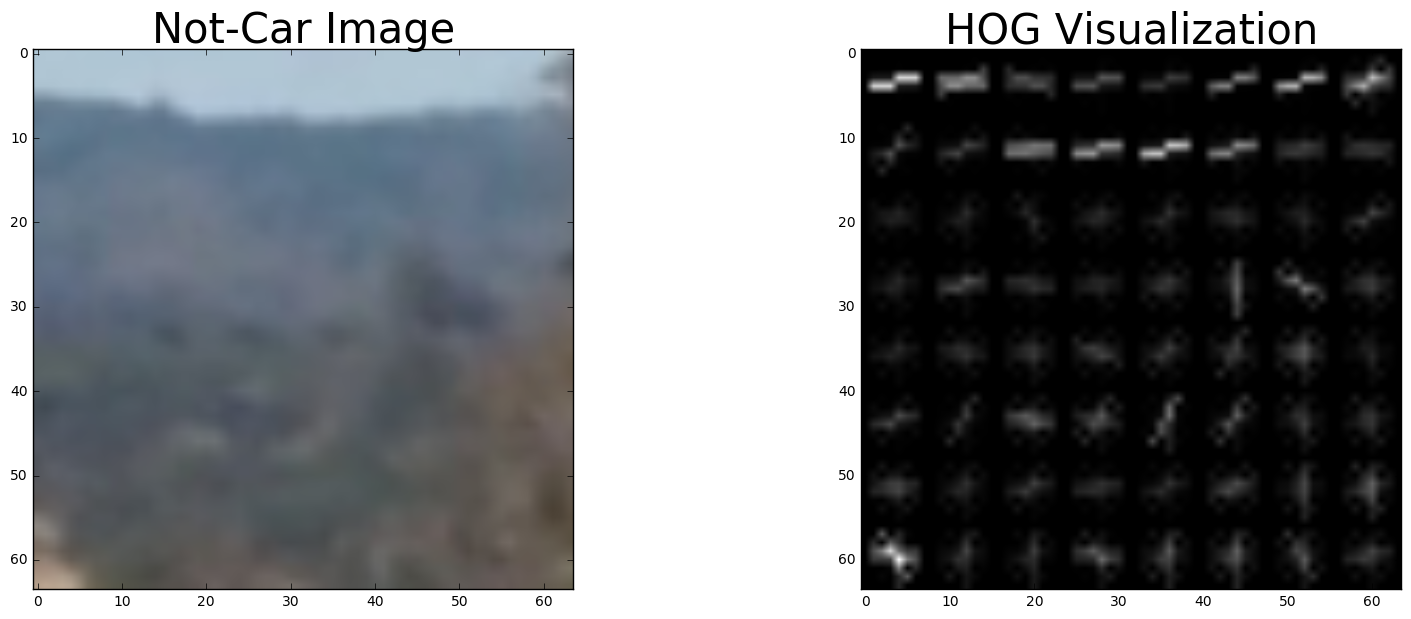

In [7]:
# Extract HOG features
features, hog_image = hog(car_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=True, 
            feature_vector=True)

org_upd(car_image, 'Car Image', hog_image, 'HOG Visualization')
#plt.imshow(hog_image, 'gray')

features, hog_image = hog(notcar_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
            cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise=True, 
            feature_vector=True)

org_upd(notcar_image, 'Not-Car Image', hog_image, 'HOG Visualization')


In [8]:
dist_pickle = pickle.load( open("model_folder/svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]


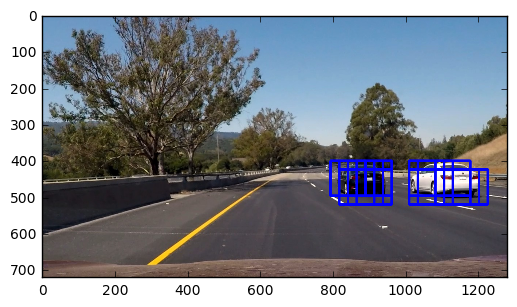

In [9]:
# 2. Look into searching an image for detections
image = mpimg.imread('test_images/test6.jpg')

draw_image = np.copy(image)
image = image.astype(np.float32)/255   # Use this to convert from JPEG (0-255) to PNG (0-1)
#print("Image min-max: ",np.min(image), np.max(image))

hot_windows = []

t0 = time.time()

subsampled_win, count = cvfind_cars.hog_subsampling(image, svc, X_scaler, 64, 1.5, 400, 656)
hot_windows.extend(subsampled_win)

t1 = time.time()

window_img,_ = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)


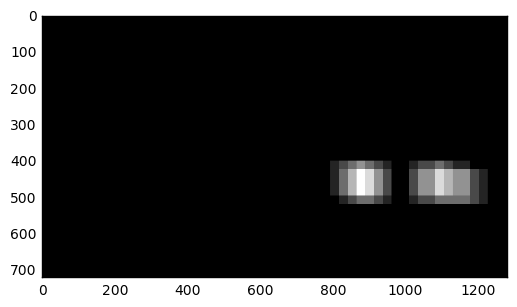

In [10]:
# A tight bounding box for each car is what you're aiming for
# These bounding boxes are going to be used by your path-planning or motion control algorithms
# to try to cause the steer is clear of the other vehicles
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = cvfind_cars.add_heat(heat,hot_windows)

plt.imshow(heat,'gray')


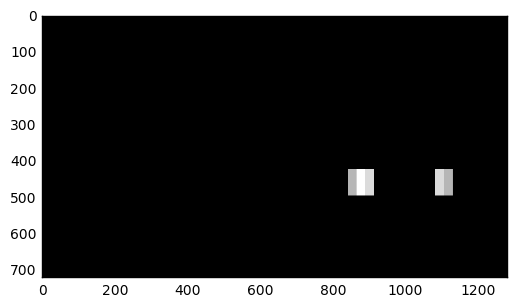

In [11]:
# Apply threshold to help remove false positives
heat = cvfind_cars.apply_threshold(heat,heatmap_thresh)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap,'gray')


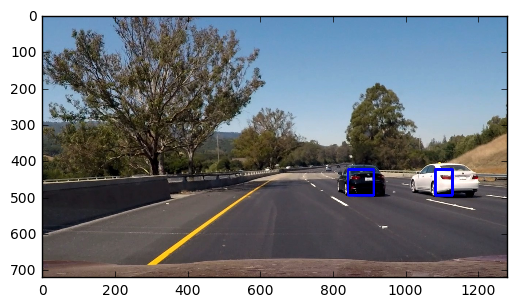

In [12]:
# Find final boxes from heatmap using label function
labels = label(heatmap)

draw_labelled = draw_labeled_bboxes(draw_image, labels)

plt.imshow(draw_labelled)



In [13]:
# Global parameters required to process successive frames
hot_windows_list = []

def process(image):
    
    global hot_windows_list
    
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255   # Use this to convert from JPEG (0-255) to PNG (0-1)
    #print("Image min-max: ",np.min(image), np.max(image))

    hot_windows = []

    m = len(hot_windows_list)

    subsampled_win, count = cvfind_cars.hog_subsampling(image, svc, X_scaler, 64, 1.5, 400, 656)
    hot_windows.extend(subsampled_win)
    
    if (m >= 10):
        hot_windows_list.pop(0)
    hw_new = np.copy(hot_windows)
    hot_windows_list.append(hw_new)

    for i in range(m-1):
        hw_old = np.copy(hot_windows_list[i])
        hot_windows.extend(hw_old)

    # A tight bounding box for each car is what you're aiming for
    # These bounding boxes are going to be used by your path-planning or motion control algorithms
    # to try to cause the steer is clear of the other vehicles
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = cvfind_cars.add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = cvfind_cars.apply_threshold(heat,heatmap_thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    return draw_labeled_bboxes(draw_image, labels)


Testing... test_images/test6.jpg


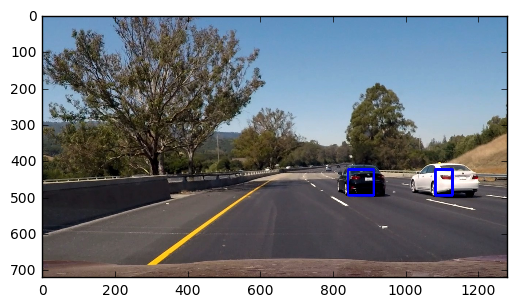

In [14]:
#image = mpimg.imread('test_images/bbox-example-image.jpg')

# Test 1-6 images
path = 'test_images/test6.jpg'
image = mpimg.imread(path)
print("Testing...", path)
draw_img = process(image)
plt.imshow(draw_img)


In [15]:
white_output = 'cv_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip('project_video.mp4').subclip(25,40) # subclip = only specified span of video
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video cv_out.mp4
[MoviePy] Writing video cv_out.mp4


100%|█████████▉| 1260/1261 [09:30<00:00,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: cv_out.mp4 

